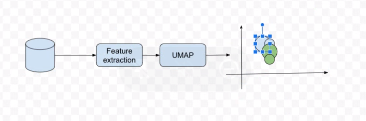

# Stacking 

## Imports

In [1]:
%%capture
#--Imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

#dendrogram
!pip install deslib
from deslib.util.diversity import double_fault
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import average, fcluster, dendrogram, ward, single
from sklearn.metrics import log_loss

#diversity analysis - Plot CPS
!pip install deslib
!pip install umap
!pip install umap-learn
import pandas as pd
import numpy as np
from sklearn.manifold import MDS, TSNE
from deslib.util.diversity import double_fault
import matplotlib.lines as mlines
!pip install 'umap-learn==0.3.10'
from matplotlib import pyplot as plt

In [2]:
from umap.umap_ import UMAP
from sklearn.metrics import precision_score, recall_score,roc_auc_score

## Data

https://www.analyticsvidhya.com/blog/2021/09/hypothesis-testing-in-machine-learning-everything-you-need-to-know/ 
https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/ 
https://machinelearningmastery.com/hypothesis-test-for-comparing-machine-learning-algorithms/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#--Files
#upload de todos os arquivos do Caso 1 manualmente do drive (=Preprocess 1: a,b,c) - ativar conexao drive 
#from google.colab import files
!mkdir Data
!mkdir Data/covid19

# 2 b + conexao drive 
train_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/train_2_b.csv')
train_2_b.to_csv('/content/Data/covid19/train_2_b.csv')
train_labels_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/train_labels_2_b.csv')
train_labels_2_b.to_csv('/content/Data/covid19/train_labels_2_b.csv')

val_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/val_2_b.csv')
val_2_b.to_csv('/content/Data/covid19/val_2_b.csv')
val_labels_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/val_labels_2_b.csv')
val_labels_2_b.to_csv('/content/Data/covid19/val_labels_2_b.csv')

test_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/test_2_b.csv')
test_2_b.to_csv('/content/Data/covid19/test_2_b.csv')
test_labels_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/test_labels_2_b.csv')
test_labels_2_b.to_csv('/content/Data/covid19/test_labels_2_b.csv')

pred_test_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/pred_test_2_b.csv')
pred_test_2_b.to_csv('/content/Data/covid19/pred_test_2_b.csv')
prob_test_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/prob_test_2_b.csv')
prob_test_2_b.to_csv('/content/Data/covid19/prob_test_2_b.csv')

pred_val_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/pred_val_2_b.csv')
pred_val_2_b.to_csv('/content/Data/covid19/pred_val_2_b.csv')
prob_val_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/prob_val_2_b.csv')
prob_val_2_b.to_csv('/content/Data/covid19/prob_val_2_b.csv')

pred_train_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/pred_train_2_b.csv')
pred_train_2_b.to_csv('/content/Data/covid19/pred_train_2_b.csv')
prob_train_2_b=pd.read_csv('/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2/prob_train_2_b.csv')
prob_train_2_b.to_csv('/content/Data/covid19/prob_train_2_b.csv')

## Funçoes 

In [5]:
#stacking
def filter_df_train_test(train_df, test_df, name, filter_first=True):
    train = train_df.filter(regex=name, axis=1)
    test = test_df.filter(regex=name, axis=1)
    return train.to_numpy(), test.to_numpy(), train.columns
def filter_collinearity(X_train, X_test):
    X_train = X_train[:, ::2]
    X_test = X_test[:, ::2]
    return X_train, X_test
def generate_confusion_matrix(stacking, X_test, labels_test, name):
    disp = plot_confusion_matrix(stacking, X_test, 
                             labels_test, cmap=plt.cm.Blues, display_labels=['True', 'Fake'])
    disp.ax_.set_title(name)
    plt.tight_layout()
    plt.savefig('confusion_matrix_' + name+'.pdf', dpi=300)
def create_coefficient_plot(coefs, names, group, savename):
    log_odds = np.exp(coefs.T)
    log_odds = pd.DataFrame(log_odds,names,['Coef']).sort_values(by='Coef', ascending=False)
    log_odds.round(3)
    log_odds.plot.bar()
    plt.ylabel('Coefficients') #LR Coefficients
    plt.xlabel(group)
    plt.tight_layout()
    plt.savefig(savename+'.pdf', dpi=300)
def organize_names_df(names):
    names_coeffs = names[::2]
    names_coeffs = [name.replace("-0", "") for name in names_coeffs]
    #names_coeffs = [name.replace("-CV", "-TF") for name in names_coeffs]
    return names_coeffs

In [6]:
#funçoes para armazenar os 3 stackings testados, independe de arquivo 
stackingLR = ['LR',LogisticRegression(class_weight='balanced',multi_class='multinomial')]
stackingRF = ['RF',RandomForestClassifier(class_weight='balanced')]
stackingNB = ['NB',GaussianNB()]

In [7]:
def conditions_name_stacking(stacking):
  name=''
  if stacking==stackingLR[1]:
    name='LR' 
  elif stacking==stackingRF[1]:
    name='RF'
  elif stacking==stackingNB[1]:   
    name='NB'
  return name
def conditions_name_metric(metric):
  name=''
  if metric==accuracy_score:
    name='accuracy_score'
  elif metric==recall_score: 
    name='recall_score'
  elif metric==precision_score:
    name='precision_score'
  elif metric==f1_score:
    name='f1_score'
  elif metric==roc_auc_score:
    name='roc_auc_score'
  return name

In [8]:
from sklearn import metrics
#funçao de stacking A, filtra os datasets e a colinearidade. Calculada em validaçao e teste
#
def stackingA(stacking,metric):
  """metric is accuracy_score,precision_score,recall_score,f_measure,roc_auc_score"""
  algorithms_list = ['SVM', 'LR','RF','NB','MLP', 'EXTRA','KNN','CNN']
  results_A = np.zeros(len(algorithms_list))
  for idx_alg, algorithm in enumerate(algorithms_list):
    X_val, X_test, cols = filter_df_train_test(probas_val, probas_test, algorithm)
    X_val, X_test = filter_collinearity(X_val, X_test)
    stacking.fit(X_val, labels_val)
    y_pred = stacking.predict(X_test)
    score = round(metric(labels_test, y_pred),3)
    stack=conditions_name_stacking(stacking)
    name=conditions_name_metric(metric)
    #enerate_confusion_matrix(stacking, X_test, labels_test,'Confusion Matrix - Group A - '+stack+' - '+str(algorithm)+' - '+name)
    results_A[idx_alg] = score
  return results_A

In [9]:
def stackingA_print(stacking,metric):
  algorithms_list = ['SVM', 'LR','RF','NB','MLP', 'EXTRA','KNN','CNN']
  results_A = np.zeros(len(algorithms_list))
  for idx_alg, algorithm in enumerate(algorithms_list):
    X_val, X_test, cols = filter_df_train_test(probas_val, probas_test, algorithm)
    X_val, X_test = filter_collinearity(X_val, X_test)
    stacking.fit(X_val, labels_val)
    y_pred = stacking.predict(X_test)
    score = round(metric(labels_test, y_pred),3)
    stack=conditions_name_stacking(stacking)
    name=conditions_name_metric(metric)
    generate_confusion_matrix(stacking, X_test, labels_test,'Confusion Matrix - Group A - '+stack+' - '+str(algorithm)+' - '+name)
    results_A[idx_alg] = score
  return print('Group A'+'-'+stack+'-'+name, results_A),results_A

In [10]:
#for stacking in [stackingLR[1],stackingRF[1],stackingNB[1]]:
#  for metric in [accuracy_score,recall_score,precision_score,f1_score,roc_auc_score]:
#    print(stackingA(stacking,metric))

In [11]:
def stackingB(stacking,metric):
  """metric is accuracy_score,precision_score,recall_score,f_measure,roc_auc_score"""
  fe_list = ['CV', 'TFIDF', 'W2V', 'GLOVE', 'FAST']
  results_B = np.zeros(len(fe_list))
  for idx_alg, fe in enumerate(fe_list):
    X_val, X_test, cols = filter_df_train_test(probas_val, probas_test, fe)
    X_val, X_test = filter_collinearity(X_val, X_test)
    stacking.fit(X_val, labels_val)
    y_pred = stacking.predict(X_test)
    results_B[idx_alg] = round(metric(labels_test, y_pred),3)
    stack=conditions_name_stacking(stacking)
    name=conditions_name_metric(metric)
    #generate_confusion_matrix(stacking, X_test, labels_test, 'Confusion Matrix - Group B - '+stack+' - '+fe+' - '+name)
    #generate_confusion_matrix(stacking, X_test, labels_test, name)
  return results_B

In [12]:
def stackingB_print(stacking,metric):
  fe_list = ['CV', 'TFIDF', 'W2V', 'GLOVE', 'FAST']
  results_B = np.zeros(len(fe_list))
  for idx_alg, fe in enumerate(fe_list):
    X_val, X_test, cols = filter_df_train_test(probas_val, probas_test, fe)
    X_val, X_test = filter_collinearity(X_val, X_test)
    stacking.fit(X_val, labels_val)
    y_pred = stacking.predict(X_test)
    results_B[idx_alg] = round(metric(labels_test, y_pred),3)
    stack=conditions_name_stacking(stacking)
    name=conditions_name_metric(metric)
    generate_confusion_matrix(stacking, X_test, labels_test, 'Confusion Matrix - Group B - '+stack+' - '+fe+' - '+name)
    #generate_confusion_matrix(stacking, X_test, labels_test, name)
  return print('Group B'+'-'+stack+'-'+name,results_B)

In [13]:
#for stacking in [stackingLR[1],stackingRF[1],stackingNB[1]]:
#  for metric in [accuracy_score,recall_score,precision_score,f1_score,roc_auc_score]:
#    stackingB(stacking,metric)

In [14]:
#preparando a lista 1 que é com os nomes das combinaçoes para o Grupo D 
lista_1=['CNN-CV','KNN-W2V','KNN-FAST','CNN-GLOVE','CNN-FAST','CNN-TFIDF','CNN-W2V','MLP-FAST','EXTRA-CV','EXTRA-TFIDF','EXTRA-GLOVE',
'KNN-TFIDF','KNN-GLOVE','KNN-CV','EXTRA-W2V','EXTRA-FAST','NB-FAST','MLP-CV','MLP-TFIDF','MLP-GLOVE',
'MLP-W2V','NB-CV','RF-W2V','RF-FAST','NB-W2V','NB-TFIDF','NB-GLOVE','SVM-W2V','SVM-GLOVE','SVM-CV',
'SVM-TFIDF','RF-TFIDF','RF-GLOVE','LR-FAST','RF-CV','SVM-FAST','LR-CV','LR-W2V','LR-TFIDF','LR-GLOVE']

#dendrogram e CPS
def compute_pairwise_diversity_matrix(targets, prediction_matrix, diversity_func):
    n_classifiers = prediction_matrix.shape[1]
    diversity = np.zeros((n_classifiers, n_classifiers))
    for clf_index in range(n_classifiers):
        for clf_index2 in range(clf_index + 1, n_classifiers):
            this_diversity = diversity_func(targets,
                                            prediction_matrix[:, clf_index],
                                            prediction_matrix[:, clf_index2])

            diversity[clf_index, clf_index2] = this_diversity
            diversity[clf_index2, clf_index] = this_diversity

    return diversity

def load_predictions(dataset_name,path):
    #path = '/content/Data/liar/pred_val_1_a.csv'
    table_pred = pd.read_csv(path)
    print(dataset_name)
    if dataset_name == 'covid19':
        label = table_pred["label"]
        methods = table_pred.drop('label', axis=1)
    methods = methods.drop('Unnamed: 0', axis=1)
    methods = methods.drop('Unnamed: 0.1', axis=1)
    return label, methods

#for stacking in [stackingLR[1],stackingRF[1],stackingNB[1]]:
#  for metrics in [accuracy_score,recall_score,precision_score,f1_score,roc_auc_score]:
#    stackingC(stacking,metrics)

def stackingC_print(stacking,metric):
  """metric is accuracy_score,precision_score,recall_score,f_measure,roc_auc_score"""
  results_C = 0
  X_val, X_test = filter_collinearity(probas_val.to_numpy(), probas_test.to_numpy())
  stacking.fit(X_val, labels_val)
  y_pred = stacking.predict(X_test)
  results_C = round(metric(labels_test, y_pred),3)
  stack=conditions_name_stacking(stacking)
  name=conditions_name_metric(metric)
  disp = plot_confusion_matrix(stacking, X_test, labels_test,cmap=plt.cm.Blues,display_labels=['True','Fake'])
  #disp = plot_confusion_matrix(stacking_C, X_test, labels_test, cmap=plt.cm.Blues, display_labels=['False','Half-true','Mostly-true','True','Barely-true','Pants-fire'])
                             #['True','Mostly-true','Half-true','False','Barel-true','Pants-fire'])
  disp.ax_.set_title("Confusion Matrix - Group C - "+stack+' - '+name)
  #plt.rcParams["figure.figsize"] = (25,15)
  #plt.tight_layout()
  #plt.savefig('confusion_matrix_GROUP_C.pdf', dpi=300)
  return print('Group C'+'-'+stack+'-'+name,results_C)

def stackingC(stacking,metric):
  """metric is accuracy_score,precision_score,recall_score,f_measure,roc_auc_score"""
  results_C = 0
  X_val, X_test = filter_collinearity(probas_val.to_numpy(), probas_test.to_numpy())
  stacking.fit(X_val, labels_val)
  y_pred = stacking.predict(X_test)
  results_C = round(metric(labels_test, y_pred),3)
  stack=conditions_name_stacking(stacking)
  name=conditions_name_metric(metric)
  #disp = plot_confusion_matrix(stacking, X_test, labels_test,cmap=plt.cm.Blues,display_labels=['True','Fake'])
  #disp = plot_confusion_matrix(stacking_C, X_test, labels_test, cmap=plt.cm.Blues, display_labels=['False','Half-true','Mostly-true','True','Barely-true','Pants-fire'])
                             #['True','Mostly-true','Half-true','False','Barel-true','Pants-fire'])
  #disp.ax_.set_title("Confusion Matrix - Group C - "+stack+' - '+name)
  #plt.rcParams["figure.figsize"] = (25,15)
  #plt.tight_layout()
  #plt.savefig('confusion_matrix_GROUP_C.pdf', dpi=300)
  return results_C

In [15]:
#--Elbow Method 
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Retrieve-the-Clusters
def Elbow_method_graph(z,total_clusters):
  last = z[-total_clusters:, 2]
  last_rev = last[::-1]
  idxs = np.arange(1, len(last) + 1)
  plt.plot(idxs, last_rev)

  acceleration = np.diff(last, 2)  # 2nd derivative of the distances
  acceleration_rev = acceleration[::-1]
  plt.plot(idxs[:-2] + 1, acceleration_rev)
  plt.show()
  k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
  return(print("clusters:", k))

#CPS
def plot_CPS(n_classifiers,dataset_name,path,method,n_features):
  if dataset_name == 'covid19':
      label, methods = load_predictions(dataset_name,path)
      methods_name = [name.split('-', 1)[0] for name in methods.columns]
      D_tilde = compute_matrix_embedding(dataset_name=dataset_name,n_classifiers=n_classifiers, n_features=n_features,method=method)
      plot=plot_diversity(D_tilde, methods_name, dataset_name,method)
  return plot

#CPS
def plot_diversity(D_changed, method_tmp, dataset_name, title):
    s = 100
    colors = {}
    colors[0] = '#DAA520'
    colors[1] = '#FF0000'
    colors[2] = '#0000FF'
    colors[3] = '#228B22'
    colors[4] = '#000000'
    markers = {}
    markers[0] = 'X'
    markers[1] = 'd'
    markers[2] = '*'
    markers[3] = "^"
    markers[4] = 'o'
    n_classifiers, n_features, _ = D_changed.shape
    plt.figure(figsize=(15,10))
    method=0
    for idx in range(n_classifiers):
        for idx2 in range(n_features):
            x, y = D_changed[idx,idx2, 0], D_changed[idx,idx2, 1]
            plt.scatter(x, y, color=colors[idx2], s=s, lw=0, marker=markers[idx2])
            plt.annotate(method_tmp[method], xy=(x, y), textcoords='offset points', xytext=(5, 15), ha='right', va='top')  
            method += 1
    
    m1 = mlines.Line2D([], [], color=colors[0], marker=markers[0], linestyle='None', markersize=10, label='CV')
    m2 = mlines.Line2D([], [], color=colors[1], marker=markers[1], linestyle='None', markersize=10, label='TFIDF')
    m3 = mlines.Line2D([], [], color=colors[2], marker=markers[2], linestyle='None', markersize=10, label='Glove')
    m4 = mlines.Line2D([], [], color=colors[3], marker=markers[3], linestyle='None', markersize=10, label='Word2Vec')
    m5 = mlines.Line2D([], [], color=colors[4], marker=markers[4], linestyle='None', markersize=10, label='FastText')
    plt.title('CPS ' + dataset_name.upper()+' dataset')
    plt.legend(handles=[m1, m2, m3, m4, m5])
    plt.tight_layout()
    plt.savefig(title + "_" + dataset_name.upper() +'_dataset.jpg', dpi=450)
#CPS 
def compute_matrix_embedding(dataset_name, n_classifiers, n_features, method, n_neighbors=5, min_dist=0.7):
    label,methods=load_predictions(dataset_name,path) #mudança feita: acrescentei aqui essa linha e o path entrou como variavel global pra ser lida aqui
    D = compute_pairwise_diversity_matrix(label.to_numpy(), methods.to_numpy(), double_fault)
    D = 1/D
    D[D==np.inf] = 0
    if method == 'mds':
        method = MDS(dissimilarity='precomputed', random_state=123456987, n_init=20, max_iter=100000)
    elif method == 'tsne':
        method = TSNE(perplexity=25, init='pca', random_state=42, early_exaggeration=50, 
                      learning_rate=200, n_iter=2500, angle=0.5)
    else:        
        method = UMAP(n_neighbors=2, metric='euclidean', random_state=123456987, min_dist=0.7, n_components=2,)
    D_tilde = method.fit_transform(D)
    D_tilde = D_tilde.reshape(n_classifiers, n_features, 2)
    return D_tilde

def plot_graph(table_pred,stacking,metric):
  acc_cortes=[] #receber os valores de acuracia e respectivos cortes 
  for i in range(1,41): #resolver problema do 39 e 40
    a,b=stack_D_Hierarchical(k=i,table_pred=table_pred,stacking=stacking,metric=metric) 
    acc_cortes.append(a) #lista recebe o valor do resultado procurado
  X_plot=pd.DataFrame(acc_cortes)[1]
  y_plot=pd.DataFrame(acc_cortes)[0]
  return X_plot,y_plot

def stack_D_Hierarchical(k,table_pred,stacking,metric): #models_D,names,stacking):; Uso table_pred-->Calculo Ok 
  models_D=[]
  names=[]
  l = list(range(k+1))[1:] #criando lista com valor de 1 até o k
  df=stack_D_Hierarchical_df(k=k,table_pred=table_pred,metric=metric) #metric
  for item in l:
    df2=df.copy()
    window=df2.loc[df2["col0_x"] == item] #colocando o  item pra agrupar
    result_aqui=pd.DataFrame(window)
    result_aqui2=result_aqui.sort_values(by='col0_y', ascending=False) #ordenando os valores pela acuracia
    result=result_aqui2['col1'].iloc[0] #pegando o nome do maior representante do cluster, sendo o primeiro da ordenaçao decrescente
    models_D.append(result)
    names=str(models_D[0])
    for item in models_D[1:]: #https://www.simplilearn.com/tutorials/python-tutorial/list-to-string-in-python#:~:text=To%20convert%20a%20list%20to%20a%20string%2C%20use%20Python%20List,and%20return%20it%20as%20output.
      names += '|'+item
    results_D = np.zeros(len(models_D))
  sum=0.0
  for idx_alg, fe in enumerate(models_D):
    X_val, X_test, cols = filter_df_train_test(probas_val, probas_test, names)
    X_val, X_test = filter_collinearity(X_val, X_test)
    stacking.fit(X_val, labels_val)
    y_pred = stacking.predict(X_test)
    results_D[idx_alg] = round(metric(labels_test, y_pred),3)
    sum = sum + results_D[idx_alg]
  media = sum/k
  #resultado_1 = [round(results_D.mean(),3),k]
  #resultado_2 = print(models_D,"\n Results meanD1n°clusters",k, ":","acc:", round(results_D.mean(),3))
  resultado_1 = [media,k]
  resultado_2 = print(models_D,"\n Results meanD1n°clusters",k, ":","metric:")# media)
  #acc_cortes.append(round(results_D.mean(),3))
  #cortes.append(k)
  return resultado_1,resultado_2

#ver dps como programa botando self e tudo direitinho nessa parte
def stack_D_Hierarchical_df(k,table_pred,metric): #models_D,names,stacking):; O table pred pegou os arquivos certos, logo o calculo OK 
#  table=table_pred.drop(columns=['Unnamed: 0','Unnamed: 0.1','label']) #=methods
  table=table_pred.drop(columns=['Unnamed: 0','Unnamed: 0.1','label']) #=methods
  label_list=np.array(table_pred['label'])
  results=[]
  results2=[]
  for column in table.columns:
    pred_list=np.array(table[column])
    results.append([metric(label_list,pred_list),column]) #metric
  resuts=results.sort(reverse=True)
  for item in results:
    results2.append(item[1])
    df_results=pd.DataFrame(results,columns=['col0','col1'])
  if k==1:
    lista_2=fcluster(z, max_d , criterion='distance')
  elif k==40:
    lista_2=fcluster(z, min_d , criterion='distance')
  else:
    lista_2=fcluster(z, lista_distancias[k-1] , criterion='distance')
  #lista_2=fcluster ( z , k ,  criterion = 'maxclust', depth=k)
  data = {'col0': lista_2, 'col1': lista_1} #cria tabela com coluna 0 o cluster, coluna 1 o nome 
  df = pd.DataFrame(data=data)
  df2=df.merge(df_results, on='col1')  #tabela ainda nao ordenada mas com os valores de acuracia juntando 
  #df2.sort_values(by='col0_y', ascending=False) #ordenando tabela pelos valores de acuracia
  df3=df2.sort_values(by='col0_y', ascending=False)
  #l = list(range(k+1))[1:] #criando lista com valor de 1 até o k
  return df3

#rodar Z antes - Funçoes Stacking Hierarchical 
#table_pred.columns para conferir a questao das colunas Unnamed
table_pred = pd.read_csv('/content/Data/covid19/pred_val_2_b.csv')
labels = table_pred["label"]
methods = table_pred
methods = table_pred.drop('label', axis=1)
methods=methods.drop('Unnamed: 0', axis=1)
methods=methods.drop('Unnamed: 0.1', axis=1)
#label, methods = load_predictions(dataset_name='liar',path='/content/Data/covid19/pred_val_2_b.csv')
D = compute_pairwise_diversity_matrix(labels.to_numpy(), methods.to_numpy(), double_fault)
#usa Z aqui 
from scipy.cluster.hierarchy import linkage
D_prime=np.triu(D)
z = linkage(D_prime,'average')

distancias=z[-40:,2]
max_d=max(distancias)+0.1
min_d=0.0
lista_distancias=np.sort(distancias)[::-1]
#print(D.shape, D_prime.shape, z.shape)

In [16]:
#stack_D_Hierarchical_df(k=2,table_pred=table_pred,metric=metric) #metric

### Salvando resultados CSV

In [17]:
!mkdir Data/covid19/accuracy_score
!mkdir Data/covid19/precision_score
!mkdir Data/covid19/recall_score
!mkdir Data/covid19/f1_score
!mkdir Data/covid19/roc_auc_score

## Monolitics

O treinamento é feito sobre os dados de treino e as prediçoes geradas pro treino, validaçao e teste. 
Na metodologia a matriz de dissimilaridade, a reduçao da dimensionalidade, e a construçao do dendograma e do CPS sao sobre os dados de validaçao. O stacking faz o treino com os dados de validaçao e o teste com os dados de teste. Como avalia as prediçoes do stacking no conjunto de teste, os monoliticos também sao nesse.

In [18]:
files=['/content/Data/covid19/pred_test_2_b.csv']
Columns_table=['SVM-CV', 'SVM-TFIDF', 'SVM-W2V', 'SVM-GLOVE','SVM-FAST', 'LR-CV', 'LR-TFIDF', 'LR-GLOVE', 'LR-W2V', 'LR-FAST',
       'RF-CV', 'RF-TFIDF', 'RF-GLOVE', 'RF-W2V', 'RF-FAST', 'NB-CV','NB-TFIDF', 'NB-GLOVE', 'NB-W2V', 'NB-FAST', 
       'MLP-CV', 'MLP-TFIDF','MLP-GLOVE', 'MLP-W2V', 'MLP-FAST', 'EXTRA-CV', 'EXTRA-TFIDF','EXTRA-GLOVE', 'EXTRA-W2V', 'EXTRA-FAST',
       'KNN-CV', 'KNN-TFIDF','KNN-GLOVE', 'KNN-W2V', 'KNN-FAST', 'CNN-CV', 'CNN-TFIDF', 'CNN-W2V','CNN-GLOVE', 'CNN-FAST']
Results_table=pd.DataFrame(index=['P2b'],columns=Columns_table)

In [19]:
#funçao para salvar resultados grupos 2b
def saving_results_test_groups(Results_table,item,metric):#"lista 1 é com as colunas, lista 2 com as linhas" 
  Results_table.at[item,'A-SVM-LR']=stackingA(stackingLR[1],metric)[0] ## A
  Results_table.at[item,'A-LR-LR']=stackingA(stackingLR[1],metric)[1] 
  Results_table.at[item,'A-RF-LR']=stackingA(stackingLR[1],metric)[2]
  Results_table.at[item,'A-NB-LR']=stackingA(stackingLR[1],metric)[3] 
  Results_table.at[item,'A-MLP-LR']=stackingA(stackingLR[1],metric)[4]
  Results_table.at[item,'A-EXTRA-LR']=stackingA(stackingLR[1],metric)[5]
  Results_table.at[item,'A-KNN-LR']=stackingA(stackingLR[1],metric)[6]
  Results_table.at[item,'A-CNN-LR']=stackingA(stackingLR[1],metric)[7]
  Results_table.at[item,'A-SVM-RF']=stackingA(stackingRF[1],metric)[0] ## A
  Results_table.at[item,'A-LR-RF']=stackingA(stackingRF[1],metric)[1] 
  Results_table.at[item,'A-RF-RF']=stackingA(stackingRF[1],metric)[2]
  Results_table.at[item,'A-NB-RF']=stackingA(stackingRF[1],metric)[3] 
  Results_table.at[item,'A-MLP-RF']=stackingA(stackingRF[1],metric)[4]
  Results_table.at[item,'A-EXTRA-RF']=stackingA(stackingRF[1],metric)[5]
  Results_table.at[item,'A-KNN-RF']=stackingA(stackingRF[1],metric)[6]
  Results_table.at[item,'A-CNN-RF']=stackingA(stackingRF[1],metric)[7] 
  Results_table.at[item,'A-SVM-NB']=stackingA(stackingNB[1],metric)[0] ## A
  Results_table.at[item,'A-LR-NB']=stackingA(stackingNB[1],metric)[1] 
  Results_table.at[item,'A-RF-NB']=stackingA(stackingNB[1],metric)[2]
  Results_table.at[item,'A-NB-NB']=stackingA(stackingNB[1],metric)[3] 
  Results_table.at[item,'A-MLP-NB']=stackingA(stackingNB[1],metric)[4]
  Results_table.at[item,'A-EXTRA-NB']=stackingA(stackingNB[1],metric)[5]
  Results_table.at[item,'A-KNN-NB']=stackingA(stackingNB[1],metric)[6]
  Results_table.at[item,'A-CNN-NB']=stackingA(stackingNB[1],metric)[7] ##
  Results_table.at[item,'B-CV-LR']=stackingB(stackingLR[1],metric)[0] ## B 'B-TFIDF-LR','B-W2V-LR','B-GLOVE-LR','B-FAST-LR'
  Results_table.at[item,'B-TFIDF-LR']=stackingB(stackingLR[1],metric)[1] 
  Results_table.at[item,'B-W2V-LR']=stackingB(stackingLR[1],metric)[2]
  Results_table.at[item,'B-GLOVE-LR']=stackingB(stackingLR[1],metric)[3] 
  Results_table.at[item,'B-FAST-LR']=stackingB(stackingLR[1],metric)[4]
  Results_table.at[item,'B-CV-RF']=stackingB(stackingRF[1],metric)[0] ## B
  Results_table.at[item,'B-TFIDF-RF']=stackingB(stackingRF[1],metric)[1] 
  Results_table.at[item,'B-W2V-RF']=stackingB(stackingRF[1],metric)[2]
  Results_table.at[item,'B-GLOVE-RF']=stackingB(stackingRF[1],metric)[3] 
  Results_table.at[item,'B-FAST-RF']=stackingB(stackingRF[1],metric)[4]
  Results_table.at[item,'B-CV-NB']=stackingB(stackingNB[1],metric)[0] ## B
  Results_table.at[item,'B-TFIDF-NB']=stackingB(stackingNB[1],metric)[1] 
  Results_table.at[item,'B-W2V-NB']=stackingB(stackingNB[1],metric)[2]
  Results_table.at[item,'B-GLOVE-NB']=stackingB(stackingNB[1],metric)[3] 
  Results_table.at[item,'B-FAST-NB']=stackingB(stackingNB[1],metric)[4]
  Results_table.at[item,'C-LR']=stackingC(stackingLR[1],metric) ## C
  Results_table.at[item,'C-RF']=stackingC(stackingRF[1],metric) 
  Results_table.at[item,'C-NB']=stackingC(stackingNB[1],metric) 
  return Results_table


#Funçao para salvar resultados monoliticos e csv
def saving_results_test(files,Results_table,metric):
  lista_table=[]
  for element in files:
    table=pd.read_csv(element)#('/content/Data/liar/pred_test_1_a.csv')
    table=table.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
    label_list=np.array(table['label'])
    for column in table.columns:
      pred_list=np.array(table[column])
      lista_table.append([round(metric(label_list,pred_list),3),column])
    for column in Results_table:
      for i in range(len(lista_table)): 
        if column == lista_table[i][1] and element=='/content/Data/covid19/pred_test_2_b.csv':
          Results_table.at['P2b', column]=lista_table[i][0]
  return Results_table

In [20]:
train_labels=pd.read_csv('/content/Data/covid19/train_labels_2_b.csv')
val_labels=pd.read_csv('/content/Data/covid19/val_labels_2_b.csv')
test_labels=pd.read_csv('/content/Data/covid19/test_labels_2_b.csv')
val_df = pd.read_csv("/content/Data/covid19/prob_val_2_b.csv").dropna()
test_df = pd.read_csv("/content/Data/covid19/prob_test_2_b.csv").dropna()
probas_val, labels_val = val_df.drop(columns=["Unnamed: 0","Unnamed: 0.1","label"]), val_labels["label"]
probas_test, labels_test = test_df.drop(columns=["Unnamed: 0","Unnamed: 0.1","label"]), test_labels["label"]

In [21]:
!mkdir Data/covid19/accuracy_score/
!mkdir Data/covid19/precision_score/
!mkdir Data/covid19/recall_score/
!mkdir Data/covid19/f1_score/
!mkdir Data/covid19/roc_auc_score/

mkdir: cannot create directory ‘Data/covid19/accuracy_score/’: File exists
mkdir: cannot create directory ‘Data/covid19/precision_score/’: File exists
mkdir: cannot create directory ‘Data/covid19/recall_score/’: File exists
mkdir: cannot create directory ‘Data/covid19/f1_score/’: File exists
mkdir: cannot create directory ‘Data/covid19/roc_auc_score/’: File exists


In [22]:
for metric in [accuracy_score,precision_score,recall_score,f1_score,roc_auc_score]:
  path="./Data/covid19/"+str(conditions_name_metric(metric))
  results_test_monolithcs=saving_results_test(files,Results_table,metric)
  results_test_monolithcs.to_csv('{}/results_test_monolithcs.csv'.format(path))

### Caso 2 b - Grupos A/B/C

In [23]:
for metric in [accuracy_score,precision_score,recall_score,f1_score,roc_auc_score]:
  path="./Data/covid19/"+str(conditions_name_metric(metric))
  #results_test_monolithcs=saving_results_test(files,Results_table,metric)
  #results_test_monolithcs.to_csv('{}/results_test_monolithcs.csv'.format(path))
  Results_table=saving_results_test(files,Results_table,metric)
  Results_table2=Results_table.copy()
  Results_table2=saving_results_test_groups(Results_table=Results_table2,item='P2b',metric=metric)
  Results_table2.to_csv('{}/Results_table2.csv'.format(path))

In [24]:
#from scipy import cluster
#from scipy.cluster.hierarchy import median, inconsistent, maxinconsts, fclusterdata

#lista_2_a=fcluster ( z , t=0.0, criterion = 'inconsistent', depth=40)
#lista_2_b=fcluster ( z , t=0.005,  criterion = 'maxclust',depth=39)
#lista_2_b=fclusterdata( z , t=39,  criterion = 'maxclust')

#R = inconsistent(z)
#MI = maxinconsts(z, R)
#fcluster(z, t=0, criterion='maxclust_monocrit', monocrit=MI)

#max_d=max(z[-40:,2])-min(z[-40:,2])
#lista_2_c=fcluster ( z ,  t=max_d ,  criterion = 'distance')
#pega os numeros dos clusters de acordo com o elbow+dendograma o melhor numero de clusters 

#https://www.simplilearn.com/tutorials/python-tutorial/list-to-string-in-python#:~:text=To%20convert%20a%20list%20to%20a%20string%2C%20use%20Python%20List,and%20return%20it%20as%20output.
#lista_2=fcluster ( z , t=39 ,  criterion = 'maxclust', depth=39)

#depth = 40
#incons = inconsistent(z, depth)
#incons[-40:]
#I=average(incons)
#max_d=min(z[-40:,2])
#max_d=0.005
#clusters = fcluster(z, max_d, criterion='distance')

#Parte Util: 
#distances for 40 merges # based: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Retrieve-the-Clusters
#lista -> output p/teste em clusters com base na distancia 
#array([0.33375115, 0.29755633, 0.23588747, 0.2221093 , 0.21801607,
#       0.20767966, 0.19641348, 0.18383939, 0.18247886, 0.17239654,
#       0.16667005, 0.16205044, 0.1544517 , 0.15437893, 0.1476532 ,
#       0.14166587, 0.14155981, 0.1340918 , 0.13277857, 0.13245253,
#       0.1184558 , 0.11498271, 0.10586149, 0.10470731, 0.10236698,
#       0.09996178, 0.09776313, 0.09696459, 0.09683276, 0.09166981,
#       0.08139833, 0.07832506, 0.07786414, 0.07541193, 0.07060251,
#       0.0698563 , 0.06537883, 0.06016979, 0.05841121, 0.        ])

#clusters = fcluster(z,  0.34, criterion='distance') 
#print(clusters)
#1 - 0.34
#1,2 ; 1,3 ; 1-4, 1-5, 1-6 ,
#1-7, 1-8, 1-9, 1-10, 1-11,
#1-12, 1-13, 1-14, 1-15, 1-16
#1-17, 1-18, 1-19, 1-20, 1-21 
#1-22, 1-23, 1-24, 1-25, 1-26
#1-27, 1-28, 1-29, 1-30, 1-31,
#1-32, 1-33, 1-34, 1-35, 1-36
#1-37, 1-38, 1-39, 1-40

## STACKING 

### Caso 2 b - CPS

In [25]:
path='/content/Data/covid19/pred_val_2_b.csv'

covid19
covid19


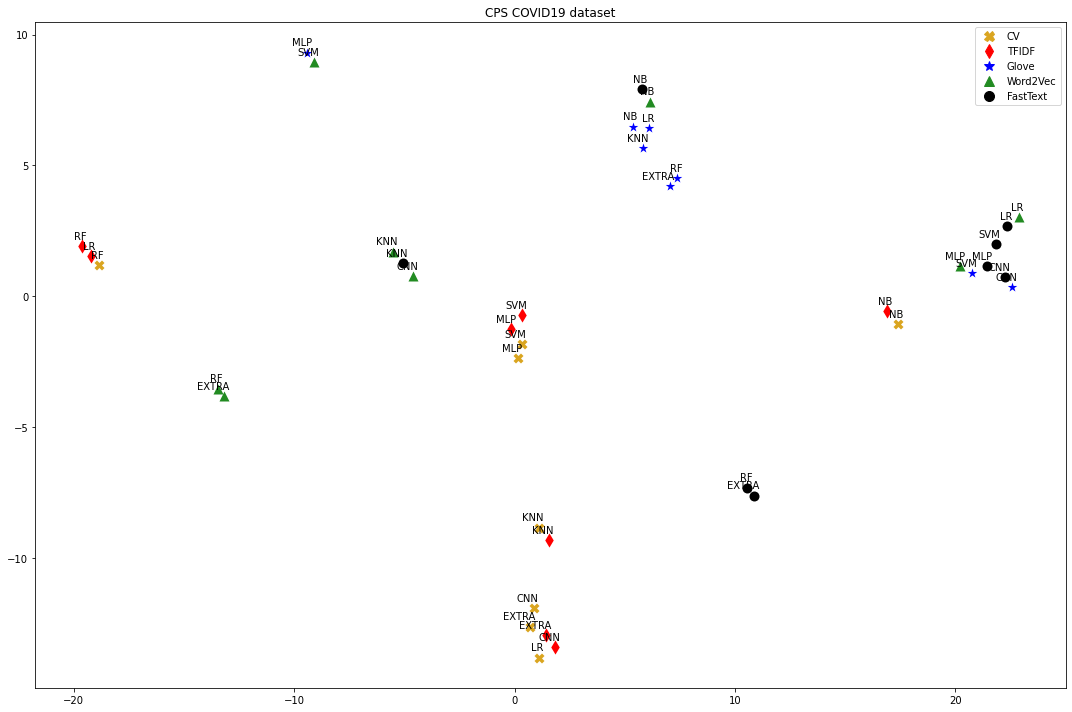

In [26]:
plot_CPS(n_classifiers=8,dataset_name='covid19',path='/content/Data/covid19/pred_val_2_b.csv',method='umap',n_features=5)

### Caso 2 b - Grupos D - Hierarchical Cluster 

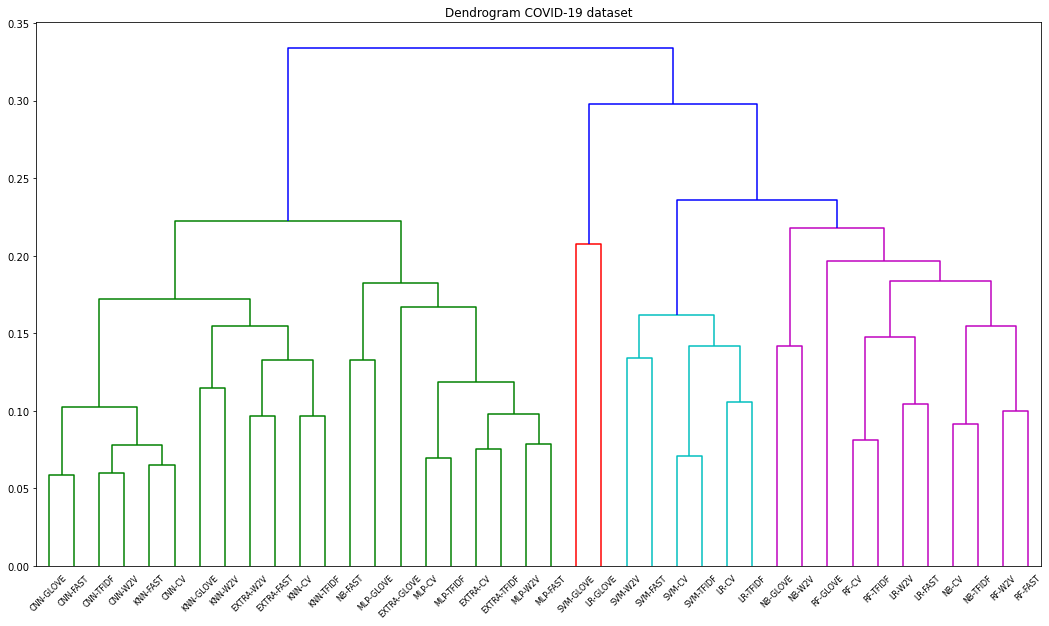

In [27]:
#from scipy.cluster.hierarchy import linkage
#preparando os dados para esse caso 
train_labels=train_labels_2_b
val_labels=val_labels_2_b
test_labels=test_labels_2_b
val_df = pd.read_csv("/content/Data/covid19/prob_val_2_b.csv").dropna()
test_df = pd.read_csv("/content/Data/covid19/prob_test_2_b.csv").dropna()

probas_val, labels_val = val_df.drop(columns=["Unnamed: 0","Unnamed: 0.1","label"]), val_labels["label"]
probas_test, labels_test = test_df.drop(columns=["Unnamed: 0","Unnamed: 0.1","label"]), test_labels["label"]

#table_pred.columns para conferir a questao das colunas Unnamed
table_pred = pd.read_csv('/content/Data/covid19/pred_val_2_b.csv')
labels = table_pred["label"]
methods = table_pred
methods = table_pred.drop('label', axis=1)
methods=methods.drop('Unnamed: 0', axis=1)
methods=methods.drop('Unnamed: 0.1', axis=1)
#label, methods = load_predictions(dataset_name='liar',path='/content/Data/covid19/pred_val_2_b.csv')
D = compute_pairwise_diversity_matrix(labels.to_numpy(), methods.to_numpy(), double_fault)

D_prime=np.triu(D)
z = linkage(D_prime,'average')
dataset_name='Covid-19'
plt.figure(figsize=(18,10))
plt.title('Dendrogram ' + dataset_name.upper()+' dataset')
dendrogram(z, labels=methods.columns)
plt.savefig('dendrogram_case2_b.jpg')

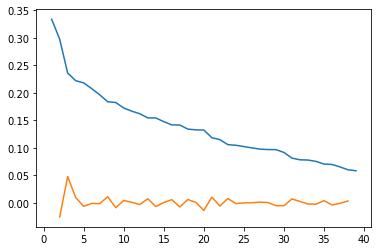

clusters: 3


In [28]:
Elbow_method_graph(z,40)

tirar duvida se faz sentido pela distribuiçao dos clusters e ver link original https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Perform-the-Hierarchical-Clustering 

In [29]:
from statistics import mean

In [31]:
#accuracy_score=acc
#recall_score=rec
#precision_score=pre
#fscore=f1
#roc_auc_score=roc

#### LR

##### Accuracy_score

In [32]:
metric=accuracy_score
stacking=stackingLR[1]

In [33]:
%%time 
%%capture
X_plot_LR_val_2b_acc,y_plot_LR_val_2b_acc=plot_graph(table_pred=table_pred,stacking=stacking,metric=metric)
X_plot_LR_test_2b_acc,y_plot_LR_test_2b_acc=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),stacking=stacking,metric=metric)

CPU times: user 2min 30s, sys: 1min 51s, total: 4min 22s
Wall time: 2min 29s


In [34]:
#print('val X and y: ',conditions_name_metric(accuracy_score), round(max(y_plot_LR_val_2b_acc),3),
#      round(mean(y_plot_LR_val_2b_acc),3))
#print('test X and y: ',conditions_name_metric(accuracy_score), round(max(y_plot_LR_test_2b_acc),3),
#      round(mean(y_plot_LR_test_2b_acc),3))
a1=round(max(y_plot_LR_val_2b_acc),3)
a2=round(mean(y_plot_LR_val_2b_acc),3)
b1=round(max(y_plot_LR_test_2b_acc),3)
b2=round(mean(y_plot_LR_test_2b_acc),3)

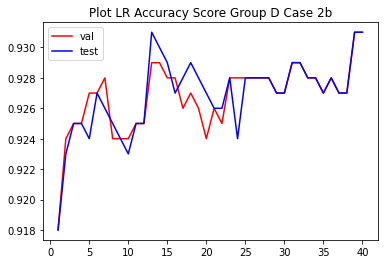

In [35]:
#conferir dados teste, usei isso pra montar tabela
Results_all=pd.read_csv('/content/Data/covid19/accuracy_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-LR-MAX']=b1
Results_all.at['P2b','D-LR-AVG']=b2
Results_all.to_csv('/content/Data/covid19/accuracy_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_LR_val_2b_acc,y_plot_LR_val_2b_acc,color='red',label='val')
plt.plot(X_plot_LR_test_2b_acc,y_plot_LR_test_2b_acc, color='blue',label='test')
plt.title('Plot LR Accuracy Score Group D Case 2b')
plt.savefig('/content/Data/covid19/accuracy_score/Plot_LR_accuracy_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### Precision

In [36]:
metric=precision_score
stacking=stackingLR[1]

In [37]:
%%time
%%capture
X_plot_LR_val_2b_pre,y_plot_LR_val_2b_pre=plot_graph(table_pred=table_pred,stacking=stacking,
                                                     metric=metric)
X_plot_LR_test_2b_pre,y_plot_LR_test_2b_pre=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 2min 49s, sys: 1min 30s, total: 4min 20s
Wall time: 3min 44s


In [38]:
a1=round(max(y_plot_LR_val_2b_pre),3)
a2=round(mean(y_plot_LR_val_2b_pre),3)
b1=round(max(y_plot_LR_test_2b_pre),3)
b2=round(mean(y_plot_LR_test_2b_pre),3)

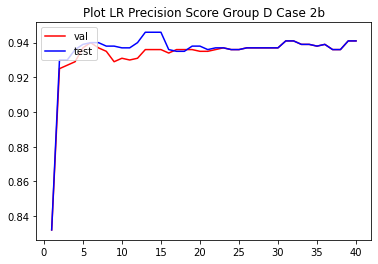

In [39]:
Results_all=pd.read_csv('/content/Data/covid19/precision_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-LR-MAX']=b1
Results_all.at['P2b','D-LR-AVG']=b2
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/precision_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_LR_val_2b_pre,y_plot_LR_val_2b_pre,color='red',label='val')
plt.plot(X_plot_LR_test_2b_pre,y_plot_LR_test_2b_pre, color='blue',label='test')
plt.title('Plot LR Precision Score Group D Case 2b')
plt.savefig('/content/Data/covid19/precision_score/Plot_LR_precision_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### Recall

In [40]:
metric=recall_score
stacking=stackingLR[1]

In [41]:
%%time
%%capture
X_plot_LR_val_2b_rec,y_plot_LR_val_2b_rec=plot_graph(table_pred=table_pred,stacking=stacking,metric=metric)
X_plot_LR_test_2b_rec,y_plot_LR_test_2b_rec=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 2min 47s, sys: 1min 30s, total: 4min 18s
Wall time: 3min 40s


In [42]:
a1=round(max(y_plot_LR_val_2b_rec),3)
a2=round(mean(y_plot_LR_val_2b_rec),3)
b1=round(max(y_plot_LR_test_2b_rec),3)
b2=round(mean(y_plot_LR_test_2b_rec),3)

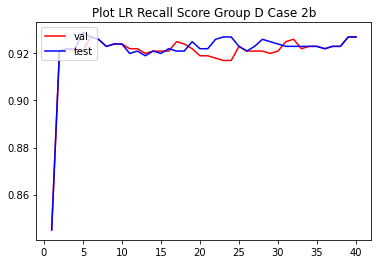

In [43]:
Results_all=pd.read_csv('/content/Data/covid19/recall_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-LR-MAX']=b1 #0.929
Results_all.at['P2b','D-LR-AVG']=b2 #0.921
#Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/recall_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_LR_val_2b_rec,y_plot_LR_val_2b_rec,color='red',label='val')
plt.plot(X_plot_LR_test_2b_rec,y_plot_LR_test_2b_rec, color='blue',label='test')
plt.title('Plot LR Recall Score Group D Case 2b')
plt.savefig('/content/Data/covid19/recall_score/Plot_LR_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### F-measure

In [45]:
metric=f1_score
stacking=stackingLR[1]

In [46]:
%%time
%%capture
X_plot_LR_val_2b_f1,y_plot_LR_val_2b_f1=plot_graph(table_pred=table_pred,stacking=stacking,metric=metric)
X_plot_LR_test_2b_f1,y_plot_LR_test_2b_f1=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 2min 45s, sys: 1min 28s, total: 4min 14s
Wall time: 3min 39s


In [47]:
a1=round(max(y_plot_LR_val_2b_f1),3)
a2=round(mean(y_plot_LR_val_2b_f1),3)
b1=round(max(y_plot_LR_test_2b_f1),3)
b2=round(mean(y_plot_LR_test_2b_f1),3)

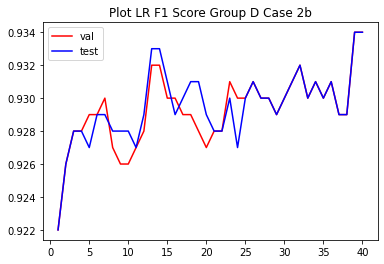

In [48]:
Results_all=pd.read_csv('/content/Data/covid19/f1_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-LR-MAX']=b1 #0.934 
Results_all.at['P2b','D-LR-AVG']=b2 #0.93
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/f1_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_LR_val_2b_f1,y_plot_LR_val_2b_f1,color='red',label='val')
plt.plot(X_plot_LR_test_2b_f1,y_plot_LR_test_2b_f1, color='blue',label='test')
plt.title('Plot LR F1 Score Group D Case 2b')
plt.savefig('Plot_LR_f1_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

#### RF

##### Accuracy 

In [49]:
metric=accuracy_score
stacking=stackingRF[1]

In [50]:
%%time 
%%capture
X_plot_RF_val_2b_acc,y_plot_RF_val_2b_acc=plot_graph(table_pred=table_pred,stacking=stacking,metric=metric)
X_plot_RF_test_2b_acc,y_plot_RF_test_2b_acc=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                                       stacking=stacking,metric=metric)

CPU times: user 15min 11s, sys: 1.97 s, total: 15min 13s
Wall time: 15min 11s


In [51]:
a1=round(max(y_plot_RF_val_2b_acc),3)
a2=round(mean(y_plot_RF_val_2b_acc),3)
b1=round(max(y_plot_RF_test_2b_acc),3)
b2=round(mean(y_plot_RF_test_2b_acc),3)

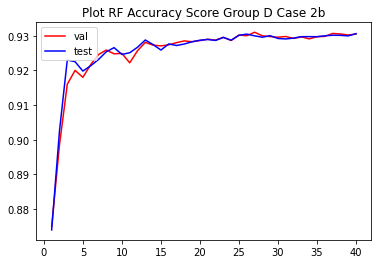

In [52]:
Results_all=pd.read_csv('/content/Data/covid19/accuracy_score/Results_table2.csv').copy()
#conferir dados teste, usei isso pra montar tabela
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-RF-MAX']=b1
Results_all.at['P2b','D-RF-AVG']=b2
Results_all.to_csv('/content/Data/covid19/accuracy_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_RF_val_2b_acc,y_plot_RF_val_2b_acc,color='red',label='val')
plt.plot(X_plot_RF_test_2b_acc,y_plot_RF_test_2b_acc, color='blue',label='test')
plt.title('Plot RF Accuracy Score Group D Case 2b')
plt.savefig('/content/Data/covid19/accuracy_score/Plot_RF_accuracy_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### Precision

In [53]:
metric=precision_score
stacking=stackingRF[1]

In [54]:
%%time
%%capture
X_plot_RF_val_2b_pre,y_plot_RF_val_2b_pre=plot_graph(table_pred=table_pred,stacking=stacking,
                                                     metric=metric)
X_plot_RF_test_2b_pre,y_plot_RF_test_2b_pre=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 15min 14s, sys: 2.2 s, total: 15min 16s
Wall time: 15min 15s


In [55]:
a1=round(max(y_plot_RF_val_2b_pre),3)
a2=round(mean(y_plot_RF_val_2b_pre),3)
b1=round(max(y_plot_RF_test_2b_pre),3)
b2=round(mean(y_plot_RF_test_2b_pre),3)

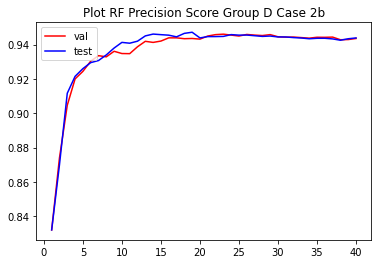

In [56]:
Results_all=pd.read_csv('/content/Data/covid19/precision_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-RF-MAX']=b1 #0.948
Results_all.at['P2b','D-RF-AVG']=b2 #0.937
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/precision_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_RF_val_2b_pre,y_plot_RF_val_2b_pre,color='red',label='val')
plt.plot(X_plot_RF_test_2b_pre,y_plot_RF_test_2b_pre, color='blue',label='test')
plt.title('Plot RF Precision Score Group D Case 2b')
plt.savefig('/content/Data/covid19/precision_score/Plot_RF_precision_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### Recall

In [57]:
metric=recall_score
stacking=stackingRF[1]

In [58]:
%%time
%%capture
X_plot_RF_val_2b_rec,y_plot_RF_val_2b_rec=plot_graph(table_pred=table_pred,stacking=stacking,
                                                     metric=metric)
X_plot_RF_test_2b_rec,y_plot_RF_test_2b_rec=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 15min 12s, sys: 2.62 s, total: 15min 14s
Wall time: 15min 13s


In [59]:
a1=round(max(y_plot_RF_val_2b_rec),3)
a2=round(mean(y_plot_RF_val_2b_rec),3)
b1=round(max(y_plot_RF_test_2b_rec),3)
b2=round(mean(y_plot_RF_test_2b_rec),3)

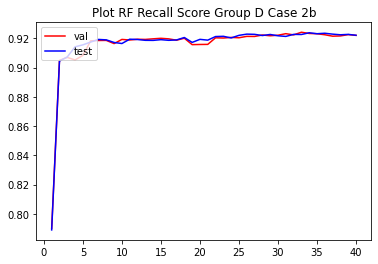

In [60]:
Results_all=pd.read_csv('/content/Data/covid19/recall_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-RF-MAX']=b1
Results_all.at['P2b','D-RF-AVG']=b2
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/recall_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_RF_val_2b_rec,y_plot_RF_val_2b_rec,color='red',label='val')
plt.plot(X_plot_RF_test_2b_rec,y_plot_RF_test_2b_rec, color='blue',label='test')
plt.title('Plot RF Recall Score Group D Case 2b')
plt.savefig('/content/Data/covid19/recall_score/Plot_RF_recall_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### F measure

In [61]:
metric=f1_score
stacking=stackingRF[1]

In [62]:
%%time
%%capture
X_plot_RF_val_2b_f1,y_plot_RF_val_2b_f1=plot_graph(table_pred=table_pred,stacking=stacking,
                                                     metric=metric)
X_plot_RF_test_2b_f1,y_plot_RF_test_2b_f1=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 15min 11s, sys: 2.71 s, total: 15min 14s
Wall time: 15min 12s


In [63]:
a1=round(max(y_plot_RF_val_2b_f1),3)
a2=round(mean(y_plot_RF_val_2b_f1),3)
b1=round(max(y_plot_RF_test_2b_f1),3)
b2=round(mean(y_plot_RF_test_2b_f1),3)

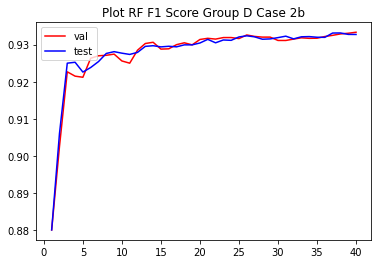

In [64]:
Results_all=pd.read_csv('/content/Data/covid19/f1_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-RF-MAX']=b1 #0.946
Results_all.at['P2b','D-RF-AVG']=b2 #0.935
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/f1_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_RF_val_2b_f1,y_plot_RF_val_2b_f1,color='red',label='val')
plt.plot(X_plot_RF_test_2b_f1,y_plot_RF_test_2b_f1, color='blue',label='test')
plt.title('Plot RF F1 Score Group D Case 2b')
plt.savefig('/content/Data/covid19/f1_score/Plot_RF_f1_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

#### NB

##### Accuracy

In [65]:
metric=accuracy_score
stacking=stackingNB[1]

In [66]:
%%time
%%capture
X_plot_NB_val_2b_acc,y_plot_NB_val_2b_acc=plot_graph(table_pred=table_pred,stacking=stacking,
                                                     metric=metric)
X_plot_NB_test_2b_acc,y_plot_NB_test_2b_acc=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 10.9 s, sys: 753 ms, total: 11.6 s
Wall time: 11.6 s


In [67]:
a1=round(max(y_plot_NB_val_2b_acc),3)
a2=round(mean(y_plot_NB_val_2b_acc),3)
b1=round(max(y_plot_NB_test_2b_acc),3)
b2=round(mean(y_plot_NB_test_2b_acc),3)

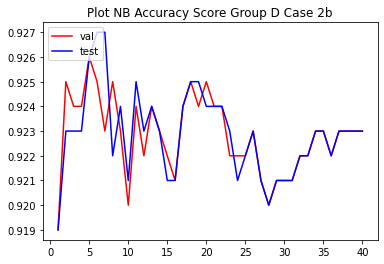

In [68]:
Results_all=pd.read_csv('/content/Data/covid19/accuracy_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-NB-MAX']=b1
Results_all.at['P2b','D-NB-AVG']=b2
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/accuracy_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_NB_val_2b_acc,y_plot_NB_val_2b_acc,color='red',label='val')
plt.plot(X_plot_NB_test_2b_acc,y_plot_NB_test_2b_acc, color='blue',label='test')
plt.title('Plot NB Accuracy Score Group D Case 2b')
plt.savefig('/content/Data/covid19/accuracy_score/Plot_NB_accuracy_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### Precision

In [69]:
metric=precision_score
stacking=stackingNB[1]

In [70]:
%%time
%%capture
X_plot_NB_val_2b_pre,y_plot_NB_val_2b_pre=plot_graph(table_pred=table_pred,stacking=stacking,
                                                     metric=metric)
X_plot_NB_test_2b_pre,y_plot_NB_test_2b_pre=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 17 s, sys: 1.64 s, total: 18.7 s
Wall time: 18.6 s


In [71]:
a1=round(max(y_plot_NB_val_2b_pre),3)
a2=round(mean(y_plot_NB_val_2b_pre),3)
b1=round(max(y_plot_NB_test_2b_pre),3)
b2=round(mean(y_plot_NB_test_2b_pre),3)

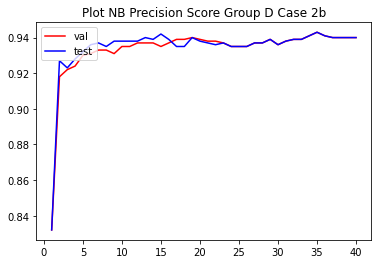

In [72]:
Results_all=pd.read_csv('/content/Data/covid19/precision_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-NB-MAX']=b1
Results_all.at['P2b','D-NB-AVG']=b2
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/precision_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_NB_val_2b_pre,y_plot_NB_val_2b_pre,color='red',label='val')
plt.plot(X_plot_NB_test_2b_pre,y_plot_NB_test_2b_pre, color='blue',label='test')
plt.title('Plot NB Precision Score Group D Case 2b')
plt.savefig('/content/Data/covid19/precision_score/Plot_NB_precision_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### Recall

In [73]:
metric=recall_score
stacking=stackingNB[1]

In [74]:
%%time
%%capture
X_plot_NB_val_2b_rec,y_plot_NB_val_2b_rec=plot_graph(table_pred=table_pred,stacking=stacking,
                                                     metric=metric)
X_plot_NB_test_2b_rec,y_plot_NB_test_2b_rec=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 18.2 s, sys: 2.47 s, total: 20.7 s
Wall time: 20.7 s


In [75]:
a1=round(max(y_plot_NB_val_2b_rec),3)
a2=round(mean(y_plot_NB_val_2b_rec),3)
b1=round(max(y_plot_NB_test_2b_rec),3)
b2=round(mean(y_plot_NB_test_2b_rec),3)

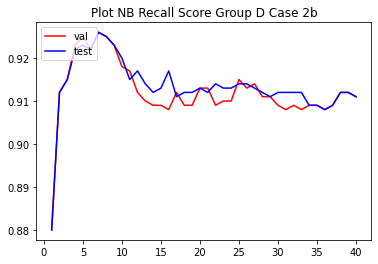

In [76]:
Results_all=pd.read_csv('/content/Data/covid19/precision_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-NB-MAX']=b1
Results_all.at['P2b','D-NB-AVG']=b2
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/recall_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_NB_val_2b_rec,y_plot_NB_val_2b_rec,color='red',label='val')
plt.plot(X_plot_NB_test_2b_rec,y_plot_NB_test_2b_rec, color='blue',label='test')
plt.title('Plot NB Recall Score Group D Case 2b')
plt.savefig('/content/Data/covid19/recall_score/Plot_NB_recall_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##### Fmeasure

In [77]:
metric=f1_score
stacking=stackingNB[1]

In [78]:
%%time
%%capture
X_plot_NB_val_2b_f1,y_plot_NB_val_2b_f1=plot_graph(table_pred=table_pred,stacking=stacking,
                                                     metric=metric)
X_plot_NB_test_2b_f1,y_plot_NB_test_2b_f1=plot_graph(table_pred=pd.read_csv('/content/Data/covid19/pred_test_2_b.csv'),
                                               stacking=stacking,metric=metric)

CPU times: user 17.1 s, sys: 640 ms, total: 17.8 s
Wall time: 17.7 s


In [79]:
a1=round(max(y_plot_NB_val_2b_f1),3)
a2=round(mean(y_plot_RF_val_2b_f1),3)
b1=round(max(y_plot_RF_test_2b_f1),3)
b2=round(mean(y_plot_RF_test_2b_f1),3)

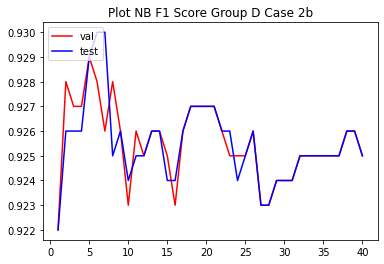

In [80]:
Results_all=pd.read_csv('/content/Data/covid19/f1_score/Results_table2.csv').copy()
Results_all=Results_all.set_index(['Unnamed: 0'])
Results_all.at['P2b','D-NB-MAX']=b1
Results_all.at['P2b','D-NB-AVG']=b2
Results_all=Results_all.copy() #conferir dados teste, usei isso pra montar tabela
Results_all.to_csv('/content/Data/covid19/f1_score/Results_table2.csv')
#plot LR curve with val and test
plt.plot(X_plot_NB_val_2b_f1,y_plot_NB_val_2b_f1,color='red',label='val')
plt.plot(X_plot_NB_test_2b_f1,y_plot_NB_test_2b_f1, color='blue',label='test')
plt.title('Plot NB F1 Score Group D Case 2b')
plt.savefig('/content/Data/covid19/f1_score/Plot_NB_f1_score_GroupD_Case_2b.jpg')
plt.legend(loc="upper left")
plt.show()

##SAVING FILES

In [ ]:
!cp -r "/content/Data/covid19/accuracy_score/dendrogram_case2_b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_plots/"


In [ ]:
/content/Data/covid19/accuracy_score/Results_table2.csv

In [82]:
!cp -r "/content/Data/covid19/accuracy_score/results_test_monolithcs.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/accuracy_score/"
!cp -r "/content/Data/covid19/accuracy_score/Plot_LR_accuracy_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/accuracy_score/"
!cp -r "/content/Data/covid19/accuracy_score/Plot_NB_accuracy_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/accuracy_score/"
!cp -r "/content/Data/covid19/accuracy_score/Plot_RF_accuracy_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/accuracy_score/"
!cp -r "/content/Data/covid19/accuracy_score/Results_table2.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/accuracy_score/"
!cp -r "/content/Data/covid19/accuracy_score/results_test_monolithcs.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/accuracy_score/"

In [85]:
!cp -r "/content/Data/covid19/precision_score/results_test_monolithcs.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/precision_score/"
!cp -r "/content/Data/covid19/precision_score/Plot_LR_precision_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/precision_score/"
!cp -r "/content/Data/covid19/precision_score/Plot_NB_precision_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/precision_score/"
!cp -r "/content/Data/covid19/precision_score/Plot_RF_precision_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/precision_score/"
!cp -r "/content/Data/covid19/precision_score/Results_table2.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/precision_score/"
!cp -r "/content/Data/covid19/precision_score/results_test_monolithcs.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/precision_score/"

In [87]:
!cp -r "/content/Data/covid19/recall_score/results_test_monolithcs.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/recall_score/"
!cp -r "/content/Data/covid19/recall_score/Plot_LR_recall_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/recall_score/"
!cp -r "/content/Data/covid19/recall_score/Plot_NB_recall_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/recall_score/"
!cp -r "/content/Data/covid19/recall_score/Plot_RF_recall_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/recall_score/"
!cp -r "/content/Data/covid19/recall_score/Results_table2.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/recall_score/"
!cp -r "/content/Data/covid19/recall_score/results_test_monolithcs.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/recall_score/"

cp: cannot stat '/content/Data/covid19/recall_score/Plot_LR_recall_score_GroupD_Case_2b.jpg': No such file or directory


In [88]:
!cp -r "/content/Data/covid19/f1_score/results_test_monolithcs.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/f1_score/"
!cp -r "/content/Data/covid19/f1_score/Plot_LR_f1_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/f1_score/"
!cp -r "/content/Data/covid19/f1_score/Plot_NB_f1_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/f1_score/"
!cp -r "/content/Data/covid19/f1_score/Plot_RF_f1_score_GroupD_Case_2b.jpg" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/f1_score/"
!cp -r "/content/Data/covid19/f1_score/Results_table2.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/f1_score/"
!cp -r "/content/Data/covid19/f1_score/results_test_monolithcs.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_revisando/f1_score/"

cp: cannot stat '/content/Data/covid19/f1_score/Plot_LR_f1_score_GroupD_Case_2b.jpg': No such file or directory


In [ ]:
Results_all.to_csv("/content/Results_all.csv")

In [ ]:
!cp -r "/content/Results_all.csv" "/content/drive/MyDrive/cin_Pesquisa/NLP:FakeNews/4_Codes/FN/Analysis Clusters/files_casos_1_2_3_4_revisando/COVID-19/2_plots/"

Foi feito um teste extra ja apagado mais que é  feito para saber os resultados e poder analisar com relaçao ao artigo numero 1 do ranking: https://paperswithcode.com/paper/a-heuristic-driven-ensemble-framework-for o qual usa a métrica f1. 